In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from scipy.stats import multivariate_normal
from scipy.optimize import linear_sum_assignment

In [4]:
def evl_acc(means, centroids, labels, true_labels):
    mapping = {}
    for i in range(len(centroids)):
        min_dist = np.inf
        for j in range(len(means)):
            dist = np.linalg.norm(centroids[i] - means[j])
            if dist < min_dist:
                min_dist = dist
                mapping[i] = j
    for i in range(len(labels)):
        labels[i] = mapping[labels[i]]
    acc = 0
    for i in range(len(labels)):
        if labels[i] == true_labels[i]:
            acc += 1
 
    return acc / len(labels)

In [5]:
def kmeans_obj(X, labels, centroids):
    distances = np.linalg.norm(X - centroids[labels])
    return np.sum(distances**2)

def kmeans(X, K, max_iters=100):
    # Initialization step: pick random samples as initial centroids
    centroids = X[np.random.choice(X.shape[0], K, replace=False)]
    for i in range(max_iters):
        # Assignment step: assign each point to the closest centroid
        # labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
        # new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])

        # Check for convergence
        if np.all(new_centroids == centroids):
            break
        centroids = new_centroids
    return labels, centroids


In [6]:
def gmm_negative_log_likelihood(X, labels, means, covariances):
    total_negative_log_likelihood = 0
    for k in range(len(means)):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            log_likelihood = multivariate_normal.logpdf(cluster_points, mean=means[k], cov=covariances[k])
            total_negative_log_likelihood -= np.sum(log_likelihood)  # Summing negative log likelihood
    return total_negative_log_likelihood

def gmm(X, K, max_iters=100, tol=1e-3):
    n, d = X.shape
    means = X[np.random.choice(n, K, replace=False)]
    covariances = [np.eye(d) * np.var(X, axis=0) for _ in range(K)]
    pis = np.ones(K) / K
    r = np.zeros((n, K))
    prev_log_likelihood = -np.inf

    for iteration in range(max_iters):
        for k in range(K):
            r[:, k] = pis[k] * multivariate_normal.pdf(X, mean=means[k], cov=covariances[k])

        log_likelihood = np.sum(np.log(np.dot(r, pis)))
        
        if np.abs(log_likelihood - prev_log_likelihood) <= tol:
            break
        prev_log_likelihood = log_likelihood

        r /= r.sum(axis=1, keepdims=True)

        N_k = r.sum(axis=0)
        for k in range(K):
            means[k] = np.dot(r[:, k], X) / N_k[k]
            X_centered = X - means[k]
            covariances[k] = np.dot(r[:, k] * X_centered.T, X_centered) / N_k[k]
            pis[k] = N_k[k] / n
    labels = np.argmax(r, axis=1)
    return labels, means, covariances

In [7]:
def generate_data(sigma):
    n = 100  # number of points per cluster
    P_a = np.random.multivariate_normal([-1, -1], [[2*sigma, 0.5*sigma], [0.5*sigma, 1*sigma]], n)
    P_b = np.random.multivariate_normal([1, -1], [[1*sigma, -0.5*sigma], [-0.5*sigma, 2*sigma]], n)
    P_c = np.random.multivariate_normal([0, 1], [[1*sigma, 0], [0, 2*sigma]], n)
    X = np.concatenate((P_a, P_b, P_c), axis=0)
    true_labels = np.array([0]*n + [1]*n + [2]*n)
    true_means = [[-1,-1], [1,-1], [0,1]]
    return X, true_labels, true_means

sigmas = [0.5, 1, 2, 4, 8]
kmeans_objs = []
kmeans_accuracies = []
gmm_objs = []
gmm_accuracies = []

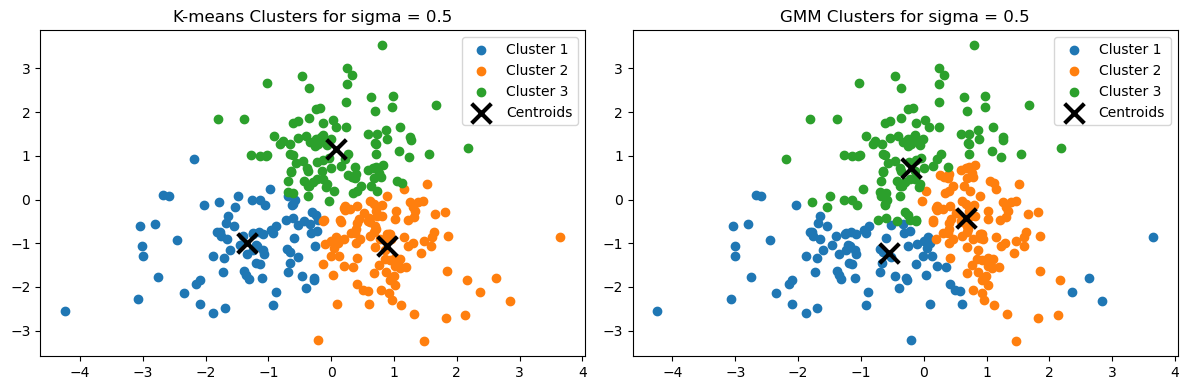

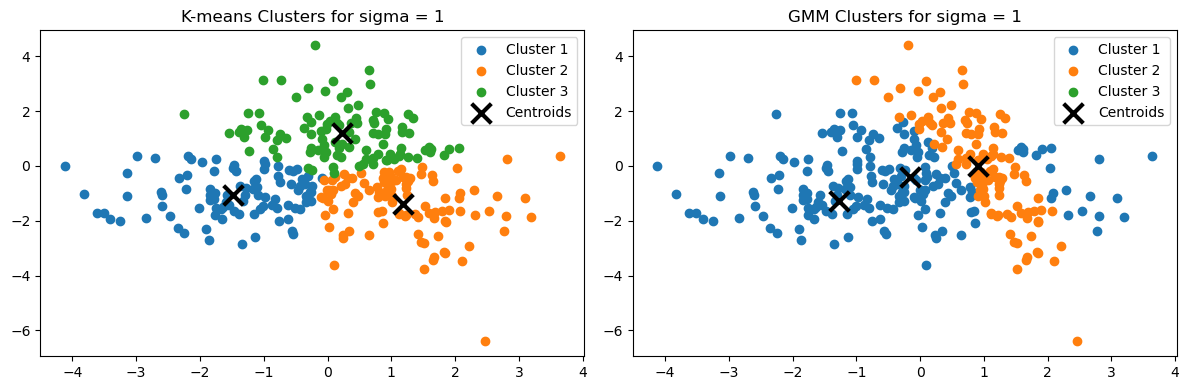

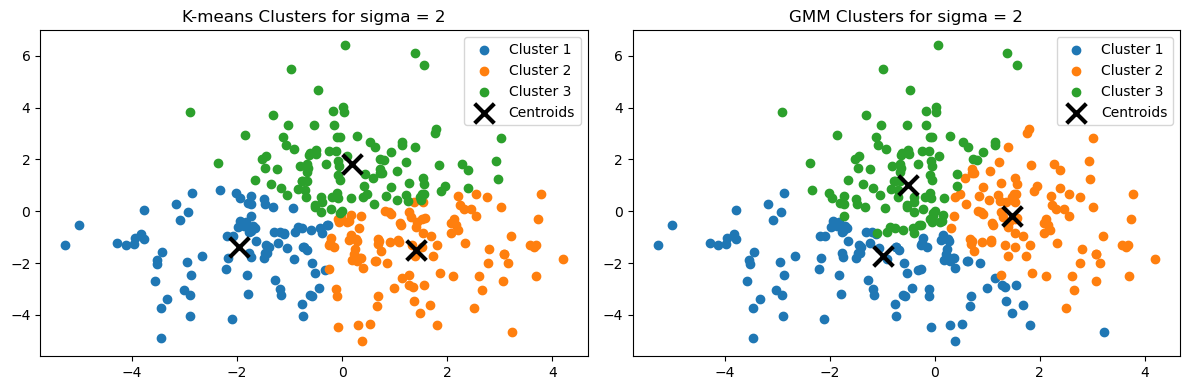

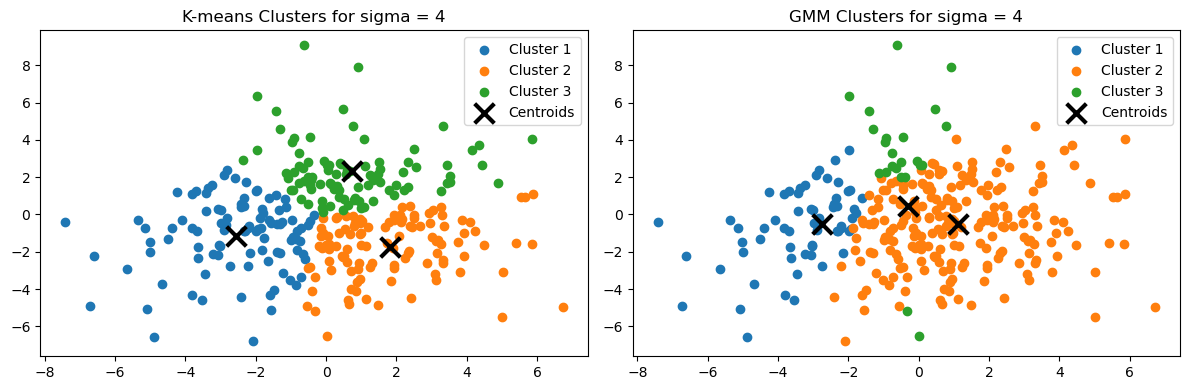

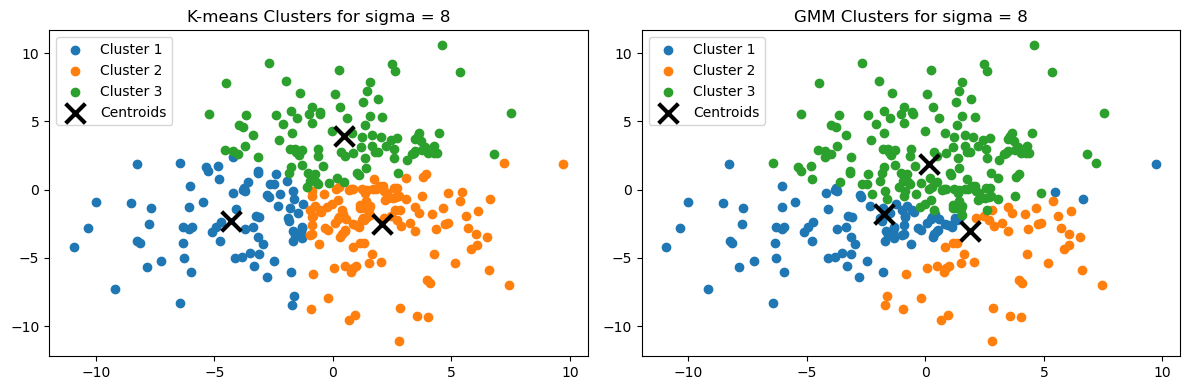

In [8]:
for sigma in sigmas:
    X, true_labels, true_means = generate_data(sigma)
    kmeans_labels, kmeans_centroids = kmeans(X, K=3)
    kmeans_objs.append(kmeans_obj(X, kmeans_labels, kmeans_centroids))
    kmeans_accuracies.append(evl_acc(true_means, kmeans_centroids, kmeans_labels, true_labels))
    gmm_labels, gmm_means, gmm_covariances = gmm(X, K=3)
    gmm_objs.append(gmm_negative_log_likelihood(X, gmm_labels, gmm_means, gmm_covariances))
    gmm_accuracies.append(evl_acc(true_means, gmm_means, gmm_labels, true_labels))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'K-means Clusters for sigma = {sigma}')
    for i in range(3):
        cluster_points = X[kmeans_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')
    plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], color='black', marker='x', linewidths = 3, s=200, label='Centroids')  # Updated this line
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title(f'GMM Clusters for sigma = {sigma}')
    for i in range(3):
        cluster_points = X[gmm_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')
    plt.scatter(gmm_means[:, 0], gmm_means[:, 1], color='black', marker='x', s=200, linewidths = 3, label='Centroids')  # Updated this line
    plt.legend()
    
    plt.tight_layout()
    plt.show()

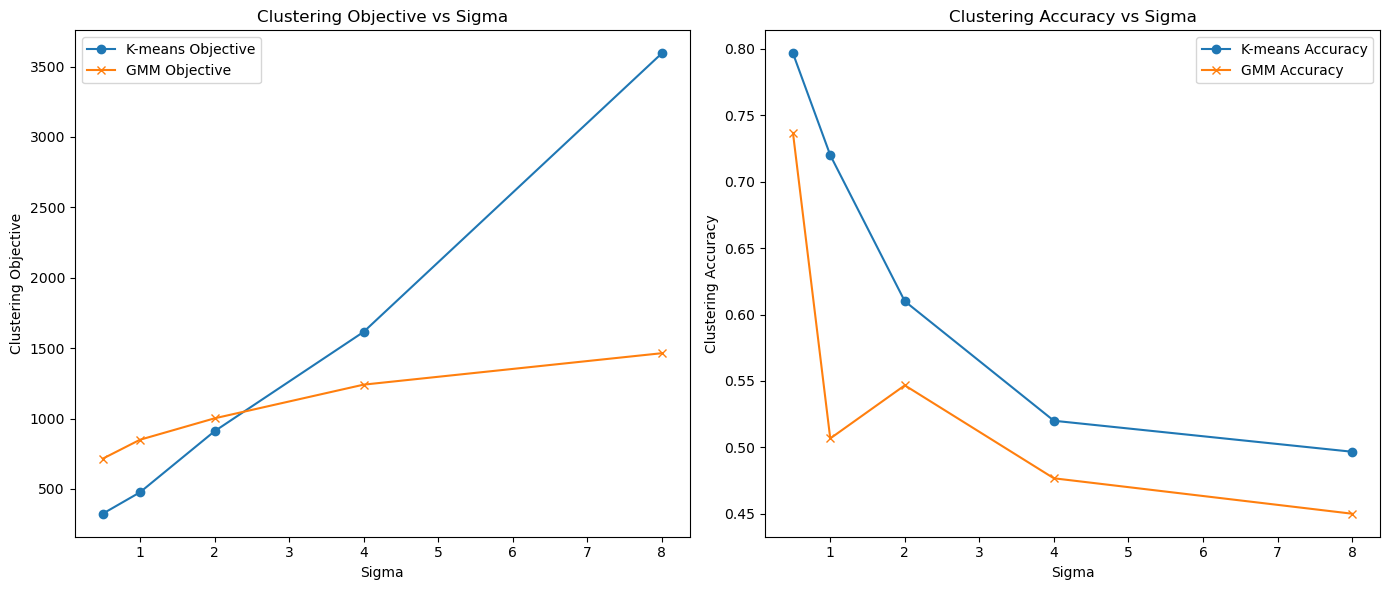

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(sigmas, kmeans_objs, marker='o', label='K-means Objective')
axs[0].plot(sigmas, gmm_objs, marker='x', label='GMM Objective')
axs[0].set_xlabel('Sigma')
axs[0].set_ylabel('Clustering Objective')
axs[0].set_title('Clustering Objective vs Sigma')
axs[0].legend()

axs[1].plot(sigmas, kmeans_accuracies, marker='o', label='K-means Accuracy')
axs[1].plot(sigmas, gmm_accuracies, marker='x', label='GMM Accuracy')
axs[1].set_xlabel('Sigma')
axs[1].set_ylabel('Clustering Accuracy')
axs[1].set_title('Clustering Accuracy vs Sigma')
axs[1].legend()

plt.tight_layout()
plt.show()

In [15]:
print(f"{'Sigma':<15}{'K-means Obj':<15}{'K-means Acc':<15}{'GMM Obj':<15}{'GMM Acc':<15}")
print('-' * 90) 
for i, sigma in enumerate(sigmas):
    print(f"{sigma:<15}{kmeans_objs[i]:<15.2f}{kmeans_accuracies[i]:<15.2f}{gmm_objs[i]:<15.2f}{gmm_accuracies[i]:<15.2f}")

Sigma          K-means Obj    K-means Acc    GMM Obj        GMM Acc        
------------------------------------------------------------------------------------------
0.5            324.40         0.80           715.20         0.74           
1              476.48         0.72           849.67         0.51           
2              909.99         0.61           1001.69        0.55           
4              1615.54        0.52           1240.86        0.48           
8              3593.38        0.50           1464.10        0.45           
